## Creating 4LAC Catalog using Goldoni's Redshift Filter

In [1]:
from astropy.io import fits
import numpy as np
from astropy.table import QTable
import astropy.units as u
from astropy.io import ascii

First set the paths of the catalog files. Note here I'm using the DR2 catalogs:

In [2]:
path_4fgl_dr2_catalog = 'input_catalogs/gll_psc_v27.fit'
path_4lac_low_gal_lat = 'input_catalogs/table-4LAC-DR2-l.fits'
path_4lac_high_gal_lat = 'input_catalogs/table-4LAC-DR2-h.fits'
# Paolo Goldoni's catalog (revised 4LAC redshifts) version 2: https://zenodo.org/record/5512660#.YVcoKHuxXRY 
path_goldoni_catalog = 'input_catalogs/4LAC_newz_AGNPop_2021.fits'

In [3]:
def read_4fgl_dr2():
    hdulist = fits.open(path_4fgl_dr2_catalog)
    ptSrcCat = hdulist[1].data
    for i, name in enumerate(ptSrcCat['Source_Name']):
        name = name.replace("4FGL ", "")
        name = name.replace(" ", "")
        if name.endswith('c'):
            name = name.replace('c', '')
        ptSrcCat['Source_Name'][i] = name
    return ptSrcCat

def read_4lac_catalog_names(filename):
    hdulist = fits.open(filename)
    ptSrcCat = hdulist[1].data
    names = ptSrcCat['Source_Name']
    sed_class = ptSrcCat['SED_class']
    redshifts = ptSrcCat['Redshift']
    for i, name in enumerate(names):
        name = name.replace("4FGL ", "")
        name = name.replace(" ", "")
        names[i] = name.replace('c', '')
    return QTable([names, redshifts, sed_class], names=('Source_Name', 'Redshift', 'SED_class'))

def read_goldoni_catalog():
    hdulist = fits.open(path_goldoni_catalog)
    goldoni = hdulist[1].data
    names = goldoni['4FGL name']
    for i, name in enumerate(names):
        names[i] = name.replace("4FGL","")
        if "J0947.1-25" in name:
            names[i] = "J0947.1-2541"
    goldoni['4FGL name'] = names
    return goldoni

def merge_4lac_and_4fgl():
    four_fgl = read_4fgl_dr2()
    four_lac_l = read_4lac_catalog_names(path_4lac_low_gal_lat)
    four_lac_h = read_4lac_catalog_names(path_4lac_high_gal_lat)

    mask_4lac = np.zeros(np.shape(four_fgl['Source_Name']), dtype=bool)
    # mask_4lac = mask_4lac*False
    for i, name in enumerate(four_fgl['Source_Name']):
        if name in four_lac_l['Source_Name']:
            mask_4lac[i] = True
        elif name in four_lac_h['Source_Name']:
            mask_4lac[i] = True
    lac_fgl_crosscatalog = QTable(four_fgl[mask_4lac])

    print("Total number of 4LAC entries found in the 4FGL: {}".format(len(lac_fgl_crosscatalog)))
    print("Total number of 4LAC entries: {}".format(len(four_lac_l)+len(four_lac_h)))
    
    # Create new column in the 4fgl
    lac_fgl_crosscatalog['Redshift'] = -1.
    redshifts_added = 0
    pos_redshifts_added = 0
    for i, name in enumerate(lac_fgl_crosscatalog['Source_Name']):
        if name in four_lac_l['Source_Name']:
            lac_fgl_crosscatalog['Redshift'][i] = four_lac_l['Redshift'][four_lac_l['Source_Name'] == name]
            redshifts_added += 1
            if four_lac_l['Redshift'][four_lac_l['Source_Name'] == name] > 0:
                pos_redshifts_added += 1
        elif name in four_lac_h['Source_Name']:
            lac_fgl_crosscatalog['Redshift'][i] = four_lac_h['Redshift'][four_lac_h['Source_Name'] == name]
            redshifts_added += 1
            if four_lac_h['Redshift'][four_lac_h['Source_Name'] == name] > 0:
                pos_redshifts_added += 1
        else:
            print("This source did not appear in neither of the 4LAC catalogs...")
    print("Added a total of {} redshifts. {} had positive values.".format(redshifts_added, pos_redshifts_added))
    return lac_fgl_crosscatalog

def add_sed_class_to_merged_4fgl_and_4lac():
    catalog = merge_4lac_and_4fgl()
    four_lac_l = read_4lac_catalog_names(path_4lac_low_gal_lat)
    four_lac_h = read_4lac_catalog_names(path_4lac_high_gal_lat)

    sed_class = []
    for source_name in catalog['Source_Name']:
        if source_name in four_lac_l['Source_Name']:
            sed_class.append(four_lac_l['SED_class'][four_lac_l['Source_Name'] == source_name][0])
        elif source_name in four_lac_h['Source_Name']:
            sed_class.append(four_lac_h['SED_class'][four_lac_h['Source_Name'] == source_name][0])
    catalog['SED_class'] = sed_class
    return catalog
    
def goldoni_revised_4lac():
    catalog = add_sed_class_to_merged_4fgl_and_4lac()
    goldoni = read_goldoni_catalog()
    # Create some variables to store statistics:
    valid_redshifts = 0
    removed_valid_redshift = 0
    added_valid_redshift = 0
    updated_value = 0
    for i, name in enumerate(catalog['Source_Name']):
        if name in goldoni['4FGL name']:
#             goldoni_redshift = goldoni['Redshift'][goldoni['4FGL name'] == name][0]
            goldoni_redshift = goldoni['Redshift_corr'][goldoni['4FGL name'] == name][0]
#             print("Updating redshift value, from {:2.3f} to {:2.3f}".format(catalog['Redshift'][i], goldoni_redshift))
            if "{:2.3f}".format(catalog['Redshift'][i]) == "{:2.6f}".format(goldoni_redshift):
                valid_redshifts += 1
            elif catalog['Redshift'][i] > 0. and goldoni_redshift > 0.:
                updated_value += 1
            elif catalog['Redshift'][i] < 0. and goldoni_redshift > 0.:
                added_valid_redshift += 1
            elif catalog['Redshift'][i] > 0. and goldoni_redshift < 0.:
                removed_valid_redshift += 1
            catalog['Redshift'][i] = "{:2.6f}".format(goldoni_redshift)
        else:
            catalog['Redshift'][i] = "{:2.6f}".format(catalog['Redshift'][i])
#         else:
#             print("{} in P. Goldoni catalog, but not within 4LAC.".format(name))
    print(" -- From Paolo's catalog -- ")
    print("A total of {} redshifts were correct within 4LAC".format(valid_redshifts))
    print("Removed a total of {} redshifts from 4LAC".format(removed_valid_redshift))
    print("Added a total of {} redshifts to 4LAC".format(added_valid_redshift))
    print("Updated a total of {} redshifts of 4LAC".format(updated_value))
    return catalog

def convert_PLSuperExpCutoff_entries_to_LogParabola(catalog):
    for i, entry in enumerate(catalog):
        if entry['SpectrumType'] == 'PLSuperExpCutoff ':
            catalog['SpectrumType'][i] = 'LogParabola      '
    return catalog
    

def create_agn_pop_shared_4lac_catalog():
    catalog = goldoni_revised_4lac()
    keep_columns = ['Source_Name', 'RAJ2000', 'DEJ2000', 'Redshift', 'SpectrumType', 'Pivot_Energy', 
                    'PL_Flux_Density', 'PL_Index', 'LP_Flux_Density', 'LP_Index', 'LP_beta', 'SED_class', 
                    'Variability_Index', 'Frac_Variability', 'Unc_Frac_Variability', 'Flux1000', 'Unc_Flux1000', 'Flux_History', 'Unc_Flux_History']
    new_catalog = QTable()
    for column in keep_columns:
        new_catalog[column] = catalog[column]
    final_catalog = convert_PLSuperExpCutoff_entries_to_LogParabola(catalog[keep_columns])
    return final_catalog


Generate the catalog and store it in a couple of different formats:

In [4]:
agn_pop_catalog = create_agn_pop_shared_4lac_catalog()
# ascii.write(agn_pop_catalog, 'resulting_catalogs/agn_pop_4lac_dr2.dat', overwrite=True)  
agn_pop_catalog.write('resulting_catalogs/agn_pop_4lac_dr2.ecsv', overwrite=True)  
agn_pop_catalog.write('resulting_catalogs/agn_pop_4lac_dr2.fits', overwrite=True)  

Total number of 4LAC entries found in the 4FGL: 3511
Total number of 4LAC entries: 3511
Added a total of 3511 redshifts. 1767 had positive values.
 -- From Paolo's catalog -- 
A total of 0 redshifts were correct within 4LAC
Removed a total of 87 redshifts from 4LAC
Added a total of 23 redshifts to 4LAC
Updated a total of 236 redshifts of 4LAC


Only selecting those sources with a valid redshift:

In [5]:
sources_with_redshift = agn_pop_catalog[agn_pop_catalog['Redshift'] > 0.]
# ascii.write(sources_with_redshift, 'resulting_catalogs/agn_pop_4lac_dr2_with_z.dat', overwrite=True)  
sources_with_redshift.write('resulting_catalogs/agn_pop_4lac_dr2_with_z.ecsv', overwrite=True)  
sources_with_redshift.write('resulting_catalogs/agn_pop_4lac_dr2_with_z.fits', overwrite=True)  

In [6]:
# sources_with_redshift

We want to analyze all of the sources:

In [7]:
agn_pop_catalog

<QTable length=3511>
Source_Name  RAJ2000  ...         Unc_Flux_History       
   str18     float32  ...          float32[10,2]         
------------ -------- ... -------------------------------
J0001.2+4741   0.3126 ... -1.7942571e-09 .. 1.8192396e-09
J0001.2-0747   0.3151 ... -1.6483049e-09 .. 1.8038276e-09
J0001.5+2113   0.3815 ... -2.7883742e-09 .. 7.1862325e-09
J0001.6-4156   0.4165 ...  -7.192918e-10 .. 6.9632494e-10
J0002.1-6728   0.5378 ...   -6.762483e-10 .. 7.001091e-10
J0002.3-0815   0.5937 ...            nan .. 1.2170501e-09
         ...      ... ...                             ...
J2359.0+3922 359.7548 ...  -2.135404e-09 .. 3.4258993e-09
J2359.0-3038 359.7719 ...  -1.0239388e-09 .. 7.973747e-10
J2359.1+1719 359.7756 ...  -6.846583e-10 .. 1.0321224e-09
J2359.2-3134 359.8167 ...            nan .. 2.3832092e-09
J2359.3+0215 359.8329 ...   -4.592819e-10 .. 9.719748e-10
J2359.3-2049 359.8357 ... -1.3597997e-09 .. 1.5734642e-09
J2359.9-3736 359.9816 ...  -1.2280752e-09 .. 1.029837e-09

## Separating into Classes (Low/ Intermediate/ High Synchrotron Peak)

Filtering only the columns we need:

In [8]:
print('List of column names:\n', agn_pop_catalog.colnames)  # List of column names
print('\nNumber of table rows:', len(agn_pop_catalog))      # Number of table rows

catalog_data = agn_pop_catalog['Source_Name', 'SpectrumType', 'Pivot_Energy', 'PL_Flux_Density', 'PL_Index', 'LP_Flux_Density', 'LP_Index', 'LP_beta', 'SED_class', 'Flux1000', 'Unc_Flux1000', 'Frac_Variability', 'Unc_Frac_Variability']

catalog_data

List of column names:
 ['Source_Name', 'RAJ2000', 'DEJ2000', 'Redshift', 'SpectrumType', 'Pivot_Energy', 'PL_Flux_Density', 'PL_Index', 'LP_Flux_Density', 'LP_Index', 'LP_beta', 'SED_class', 'Variability_Index', 'Frac_Variability', 'Unc_Frac_Variability', 'Flux1000', 'Unc_Flux1000', 'Flux_History', 'Unc_Flux_History']

Number of table rows: 3511


<QTable length=3511>
Source_Name     SpectrumType   ... Frac_Variability Unc_Frac_Variability
   str18           str17       ...     float32            float32       
------------ ----------------- ... ---------------- --------------------
J0001.2+4741 PowerLaw          ...       0.69284904           0.40699458
J0001.2-0747 PowerLaw          ...       0.33279318          0.108399756
J0001.5+2113 LogParabola       ...        1.0545832           0.24980173
J0001.6-4156 PowerLaw          ...       0.32796606           0.17213507
J0002.1-6728 PowerLaw          ...       0.30663496           0.19210596
J0002.3-0815 PowerLaw          ...       0.31231728           0.72063845
         ...               ... ...              ...                  ...
J2359.0+3922 PowerLaw          ...        0.8606212           0.25553405
J2359.0-3038 PowerLaw          ...       0.15399826           0.17869046
J2359.1+1719 PowerLaw          ...              0.0                 10.0
J2359.2-3134 PowerLaw          ...        1.2248484           0.32078165
J2359.3+0215 PowerLaw          ...        0.3452614             0.969457
J2359.3-2049 PowerLaw          ...       0.12375273           0.24667947
J2359.9-3736 PowerLaw          ...              0.0                 10.0

SED Classes in the catalog:

In [9]:
np.unique(catalog_data['SED_class'])

<Column name='SED_class' dtype='str3' length=4>
   
HSP
ISP
LSP

Filtering Low, Intermediate and High Synchrotron Peak Sources:

In [10]:
dataLSP = catalog_data[catalog_data['SED_class'] == 'LSP']
dataISP = catalog_data[catalog_data['SED_class'] == 'ISP']
dataHSP = catalog_data[catalog_data['SED_class'] == 'HSP']

Preview of each selected dataframe:

In [11]:
# dataLSP

In [12]:
dataISP

<QTable length=508>
Source_Name     SpectrumType   ... Frac_Variability Unc_Frac_Variability
   str18           str17       ...     float32            float32       
------------ ----------------- ... ---------------- --------------------
J0001.2+4741 PowerLaw          ...       0.69284904           0.40699458
J0001.5+2113 LogParabola       ...        1.0545832           0.24980173
J0004.0+0840 PowerLaw          ...        0.3789283           0.39466152
J0006.4+0135 PowerLaw          ...              0.0                 10.0
J0009.7-3217 PowerLaw          ...       0.57614726           0.27892378
J0011.4-4110 PowerLaw          ...              0.0                 10.0
         ...               ... ...              ...                  ...
J2338.1+0325 PowerLaw          ...       0.19512388           0.45357645
J2338.9+2124 PowerLaw          ...       0.33427522           0.16258197
J2341.8-2917 PowerLaw          ...              0.0                 10.0
J2346.7+0705 PowerLaw          ...       0.17739241           0.10014744
J2352.0+1750 PowerLaw          ...        0.4782953           0.15575731
J2358.1-2853 PowerLaw          ...              0.0                 10.0
J2359.1+1719 PowerLaw          ...              0.0                 10.0

In [13]:
# dataHSP

Counting how many sources were selected in each dataframe:

In [14]:
print('# of sources in:')

print('\ndataLSP:', len(dataLSP))
print('dataISP:', len(dataISP))
print('dataHSP:', len(dataHSP))

print('\ndataLSP + dataISP + dataHSP:', len(dataLSP) + len(dataISP) + len(dataHSP))
print('catalog_data:', len(catalog_data))
print('are they equal?', len(dataLSP) + len(dataISP) + len(dataHSP) == len(catalog_data))

print('\n--> difference between tables:', len(catalog_data) - (len(dataLSP)+len(dataISP)+len(dataHSP)), 'SOURCES DO NOT HAVE A SED_class REGISTERED')

# of sources in:

dataLSP: 1538
dataISP: 508
dataHSP: 548

dataLSP + dataISP + dataHSP: 2594
catalog_data: 3511
are they equal? False

--> difference between tables: 917 SOURCES DO NOT HAVE A SED_class REGISTERED


In [15]:
## Saving the dataframes as .csv tables

LSP_pandas = dataLSP.to_pandas()
ISP_pandas = dataISP.to_pandas()
HSP_pandas = dataHSP.to_pandas()
whole_data_pandas = catalog_data.to_pandas()

LSP_pandas.to_csv('LSP_data.csv', index=False)
ISP_pandas.to_csv('ISP_data.csv', index=False)
HSP_pandas.to_csv('HSP_data.csv', index=False)
whole_data_pandas.to_csv('catalog_data.csv', index=False)

## Flux1000 & Unc_Flux1000

We will use 4FGL's values of Flux1000 to compare with the Spectrum Flux we have estimated.


Flux1000 = Integral photon flux from 1 to 100 GeV

Unc Flux1000 = 1$\sigma $ error on integral photon flux from 1 to 100 GeV

In [16]:
catalog_with_flux1000 = agn_pop_catalog['Source_Name', 'Flux1000', 'Unc_Flux1000'] # 'SED_class'

catalog_with_flux1000

<QTable length=3511>
Source_Name     Flux1000    Unc_Flux1000
   str18        float32       float32   
------------ ------------- -------------
J0001.2+4741 1.2159239e-10 3.2066936e-11
J0001.2-0747 8.2320506e-10 5.6777423e-11
J0001.5+2113 1.3590526e-09 6.8598856e-11
J0001.6-4156 3.0486913e-10 3.4296448e-11
J0002.1-6728 2.4168523e-10 3.0690155e-11
J0002.3-0815 1.1693464e-10   3.32925e-11
         ...           ...           ...
J2359.0+3922 2.7603766e-10 4.0250227e-11
J2359.0-3038 4.3815906e-10 4.2386882e-11
J2359.1+1719 1.3639893e-10 3.0394815e-11
J2359.2-3134 1.7424803e-10  2.969267e-11
J2359.3+0215 1.0321737e-10 2.7625228e-11
J2359.3-2049 3.2262729e-10 3.6377887e-11
J2359.9-3736 1.7806581e-10  2.820794e-11

In [17]:
## Saving the dataframe as a .csv table

catalog_with_flux1000.to_pandas().to_csv('Flux1000_data.csv', index=False)

## Testing the Fractional Variability Parameter (F_var)

Creating a dataframe with the Fractional Variability parameter per source in the filtered catalog:

In [18]:
catalog_with_fvar = agn_pop_catalog['Source_Name', 'Frac_Variability', 'Unc_Frac_Variability'] # 'SED_class'

catalog_with_fvar

<QTable length=3511>
Source_Name  Frac_Variability Unc_Frac_Variability
   str18         float32            float32       
------------ ---------------- --------------------
J0001.2+4741       0.69284904           0.40699458
J0001.2-0747       0.33279318          0.108399756
J0001.5+2113        1.0545832           0.24980173
J0001.6-4156       0.32796606           0.17213507
J0002.1-6728       0.30663496           0.19210596
J0002.3-0815       0.31231728           0.72063845
         ...              ...                  ...
J2359.0+3922        0.8606212           0.25553405
J2359.0-3038       0.15399826           0.17869046
J2359.1+1719              0.0                 10.0
J2359.2-3134        1.2248484           0.32078165
J2359.3+0215        0.3452614             0.969457
J2359.3-2049       0.12375273           0.24667947
J2359.9-3736              0.0                 10.0

In [19]:
## Saving the dataframe as a .csv table

catalog_with_fvar.to_pandas().to_csv('Fvar_data.csv', index=False)

### Selecting the Flux History of one specific source

Selecting the source Mrk421 = 'J1104.4+3812'

In [20]:
catalog_with_fvar[catalog_with_fvar['Source_Name'] == 'J1104.4+3812']

<QTable length=1>
Source_Name  Frac_Variability Unc_Frac_Variability
   str18         float32            float32       
------------ ---------------- --------------------
J1104.4+3812       0.27904105          0.066183634

We can extract 1-year lightcurve information from the 4FGL:

In [21]:
catalog_with_flux_history = agn_pop_catalog['Source_Name', 'Flux_History', 'Unc_Flux_History']

catalog_with_flux_history

<QTable length=3511>
Source_Name           Flux_History                  Unc_Flux_History       
   str18              float32[10]                    float32[10,2]         
------------ ------------------------------ -------------------------------
J0001.2+4741  3.2381073e-09 .. 3.748821e-13 -1.7942571e-09 .. 1.8192396e-09
J0001.2-0747  9.068161e-09 .. 5.3190576e-09 -1.6483049e-09 .. 1.8038276e-09
J0001.5+2113 3.5381675e-09 .. 1.9309729e-07 -2.7883742e-09 .. 7.1862325e-09
J0001.6-4156  2.4941327e-09 .. 2.257481e-09  -7.192918e-10 .. 6.9632494e-10
J0002.1-6728 1.7362627e-09 .. 2.0357045e-09   -6.762483e-10 .. 7.001091e-10
J0002.3-0815  7.317083e-12 .. 1.5915405e-09            nan .. 1.2170501e-09
         ...                            ...                             ...
J2359.0+3922 4.2458934e-09 .. 1.6776674e-08  -2.135404e-09 .. 3.4258993e-09
J2359.0-3038 4.8273003e-09 .. 1.6648541e-09  -1.0239388e-09 .. 7.973747e-10
J2359.1+1719  7.771902e-10 .. 4.3490941e-10  -6.846583e-10 .. 1.0321224e-09
J2359.2-3134  1.0777564e-09 .. 5.405605e-12            nan .. 2.3832092e-09
J2359.3+0215  1.061645e-09 .. 2.4759987e-09   -4.592819e-10 .. 9.719748e-10
J2359.3-2049  4.3693253e-09 .. 3.524929e-09 -1.3597997e-09 .. 1.5734642e-09
J2359.9-3736  3.2138203e-09 .. 7.503538e-10  -1.2280752e-09 .. 1.029837e-09

### Testing the flux selection and Upper Limit Filter

In [22]:
## Select a single row based on the source name

# 'J2359.2-3134' / 'J1104.4+3812' / 'J0001.2+4741'

selected_source = catalog_with_flux_history[catalog_with_flux_history['Source_Name'] == 'J0001.2+4741']

In [23]:
selected_source

<QTable length=1>
Source_Name           Flux_History                 Unc_Flux_History       
   str18              float32[10]                   float32[10,2]         
------------ ----------------------------- -------------------------------
J0001.2+4741 3.2381073e-09 .. 3.748821e-13 -1.7942571e-09 .. 1.8192396e-09

In [24]:
## Flux Points

selected_source['Flux_History'][0][:]

array([3.2381073e-09, 6.2654388e-09, 5.3481841e-09, 7.9557583e-14,
       6.5167382e-15, 3.0029751e-14, 3.4034604e-09, 1.1556166e-09,
       2.0116395e-09, 3.7488209e-13], dtype=float32)

In [25]:
## Unc Flux Points

selected_source['Unc_Flux_History'][0][:]

array([[-1.7942571e-09,  2.0774948e-09],
       [-1.8782995e-09,  2.1424658e-09],
       [-1.9150088e-09,  2.1906275e-09],
       [           nan,  1.3167837e-09],
       [           nan,  1.6244933e-09],
       [           nan,  2.3319167e-09],
       [-1.9609092e-09,  2.3040045e-09],
       [           nan,  1.6207169e-09],
       [-1.2986654e-09,  1.6936006e-09],
       [           nan,  1.8192396e-09]], dtype=float32)

In [26]:
## Extracting flux points and errors

## creating a mask for upper limits
mask_source = np.invert(np.isnan(selected_source['Unc_Flux_History'][0][:,0]))

## selecting the values that are not Upper Limits
source_flux = selected_source['Flux_History'][0][mask_source]

## choose the positive uncertainties (seems larger)
source_flux_unc = selected_source['Unc_Flux_History'][0][:,1][mask_source]

In [27]:
source_flux

array([3.2381073e-09, 6.2654388e-09, 5.3481841e-09, 3.4034604e-09,
       2.0116395e-09], dtype=float32)

In [28]:
source_flux_unc

array([2.0774948e-09, 2.1424658e-09, 2.1906275e-09, 2.3040045e-09,
       1.6936006e-09], dtype=float32)

In [29]:
## Save the arrays with flux information to a file

np.savez('source_flux_arrays.npz', array1=source_flux, array2=source_flux_unc)

# Calculating F_var for all of the sources using the History Flux

Using 2 approaches:

- [Vaughan et. al 2003](https://articles.adsabs.harvard.edu/pdf/2003MNRAS.345.1271V)

- 4FGL paper: [Abdollahi et. al 2020](https://arxiv.org/pdf/1902.10045.pdf)

And the Flux History values from 4FGL:

In [30]:
catalog_with_flux_history

<QTable length=3511>
Source_Name           Flux_History                  Unc_Flux_History       
   str18              float32[10]                    float32[10,2]         
------------ ------------------------------ -------------------------------
J0001.2+4741  3.2381073e-09 .. 3.748821e-13 -1.7942571e-09 .. 1.8192396e-09
J0001.2-0747  9.068161e-09 .. 5.3190576e-09 -1.6483049e-09 .. 1.8038276e-09
J0001.5+2113 3.5381675e-09 .. 1.9309729e-07 -2.7883742e-09 .. 7.1862325e-09
J0001.6-4156  2.4941327e-09 .. 2.257481e-09  -7.192918e-10 .. 6.9632494e-10
J0002.1-6728 1.7362627e-09 .. 2.0357045e-09   -6.762483e-10 .. 7.001091e-10
J0002.3-0815  7.317083e-12 .. 1.5915405e-09            nan .. 1.2170501e-09
         ...                            ...                             ...
J2359.0+3922 4.2458934e-09 .. 1.6776674e-08  -2.135404e-09 .. 3.4258993e-09
J2359.0-3038 4.8273003e-09 .. 1.6648541e-09  -1.0239388e-09 .. 7.973747e-10
J2359.1+1719  7.771902e-10 .. 4.3490941e-10  -6.846583e-10 .. 1.0321224e-09
J2359.2-3134  1.0777564e-09 .. 5.405605e-12            nan .. 2.3832092e-09
J2359.3+0215  1.061645e-09 .. 2.4759987e-09   -4.592819e-10 .. 9.719748e-10
J2359.3-2049  4.3693253e-09 .. 3.524929e-09 -1.3597997e-09 .. 1.5734642e-09
J2359.9-3736  3.2138203e-09 .. 7.503538e-10  -1.2280752e-09 .. 1.029837e-09

## Approach 1) Vaughan et. al 2003: F_var Calculations

$$ F_{var} = \sqrt{ \frac{ S^{2} - < \sigma _{err}^{2} > }{ < F_{\gamma } >^{2} } } $$

$$ err(F_{var}) = \sqrt{ \left ( \sqrt{\frac{1}{2N}} \frac{< \sigma _{err}^{2} >}{< F_{\gamma } >^{2} \ F_{var}}  \right )^{2} + \left ( \sqrt{\frac{< \sigma _{err}^{2} >}{N}} \frac{1}{< F_{\gamma } >}  \right )^{2} } $$

In [31]:
## F_var without considering UL, only the flux points

from sklearn.metrics import mean_squared_error

def calculate_Fvar_Vaughan(history_flux, flux_error):
    ########## Description ##########
    # ---------- Input ----------
    # history_flux : history flux points from 4FGL                 (float)
    # flux_error   : error of the flux value                         (1D-array)
    # ---------- Output ----------
    # Fvar         : Fvar of the source            (float)
    # Fvar_error   : error of the value Fvar       (float)
    #################################
    
    n = len(history_flux)
    s_std = np.std(history_flux, ddof=1)
    photon_flux_average = np.average(history_flux)
    mse = ((flux_error)**2).mean(axis=None)
    
    Fvar = np.sqrt((s_std**2 + mse**2)/ photon_flux_average**2)
    
    factor1 = np.sqrt( 1 / (2*n) ) * mse / ( photon_flux_average**2 * Fvar )
    factor2 = np.sqrt( mse / n ) * ( 1 / photon_flux_average )
    
    Fvar_error = np.sqrt( (factor1)**2 + (factor2)**2 )
    
    return Fvar, Fvar_error

In [32]:
## Calculating F_var for each source

source_names_Vaughan = []
f_var_sources_Vaughan = []
source_has_UL_Vaughan = []
average_flux_Vaughan = []

f_var_unc_sources_Vaughan = []


for i in range(len(catalog_with_flux_history)):
    
    ## Selecting each source by name
    select_source = catalog_with_flux_history['Source_Name'][i]
    source_names_Vaughan.append(f'{select_source}')
    
    ## Selecting the dataframe of the selected source
    source_df = catalog_with_flux_history[catalog_with_flux_history['Source_Name'] == f'{select_source}']

    source_flux_history = source_df['Flux_History'][0][:]
    source_unc_flux = source_df['Unc_Flux_History'][0][:]
    
    ## Creating a mask for upper limits
    mask_this_source = np.invert(np.isnan(source_df['Unc_Flux_History'][0][:,0]))

    ## Selecting the values that are not Upper Limits
    source_flux_history = source_df['Flux_History'][0][mask_this_source]

    ## Choose the positive uncertainties (seems larger)
    source_unc_flux = source_df['Unc_Flux_History'][0][:,1][mask_this_source]
    
    if (len(source_flux_history) == 10):
        source_has_UL_Vaughan.append(False)
    else:
        source_has_UL_Vaughan.append(True)

    average_flux_Vaughan.append(np.average(source_flux_history))
    
    fvar_source, fvar_unc_source = calculate_Fvar_Vaughan(source_flux_history, source_unc_flux)
    f_var_sources_Vaughan.append(fvar_source)
    f_var_unc_sources_Vaughan.append(fvar_unc_source)
    
    
# print(source_names)
# print(source_has_UL)
# print(f_var_sources)

/Users/luanareis/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/luanareis/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


In [33]:
len(source_names_Vaughan)

3511

In [34]:
import pandas as pd
import matplotlib.pyplot as plt

fvar_Luana_Vaughan = pd.DataFrame({'Source_Name': source_names_Vaughan, 'Frac_Variability': f_var_sources_Vaughan,
                           'Unc_Frac_Variability': f_var_unc_sources_Vaughan, 'Upper_limits': source_has_UL_Vaughan})

fvar_Luana_Vaughan

Source_Name  Frac_Variability  Unc_Frac_Variability  Upper_limits
0     J0001.2+4741          0.424193              0.304473          True
1     J0001.2-0747          0.391219              0.071771         False
2     J0001.5+2113          1.057198              0.023527         False
3     J0001.6-4156          0.489404              0.139981         False
4     J0002.1-6728          0.499919              0.158483         False
...            ...               ...                   ...           ...
3506  J2359.1+1719          0.463074              0.397809          True
3507  J2359.2-3134          0.815916              0.114992          True
3508  J2359.3+0215          0.734690              0.350671          True
3509  J2359.3-2049          0.359884              0.142461         False
3510  J2359.9-3736          0.269654              0.298104          True

[3511 rows x 4 columns]

In [35]:
catalog_with_fvar

<QTable length=3511>
Source_Name  Frac_Variability Unc_Frac_Variability
   str18         float32            float32       
------------ ---------------- --------------------
J0001.2+4741       0.69284904           0.40699458
J0001.2-0747       0.33279318          0.108399756
J0001.5+2113        1.0545832           0.24980173
J0001.6-4156       0.32796606           0.17213507
J0002.1-6728       0.30663496           0.19210596
J0002.3-0815       0.31231728           0.72063845
         ...              ...                  ...
J2359.0+3922        0.8606212           0.25553405
J2359.0-3038       0.15399826           0.17869046
J2359.1+1719              0.0                 10.0
J2359.2-3134        1.2248484           0.32078165
J2359.3+0215        0.3452614             0.969457
J2359.3-2049       0.12375273           0.24667947
J2359.9-3736              0.0                 10.0

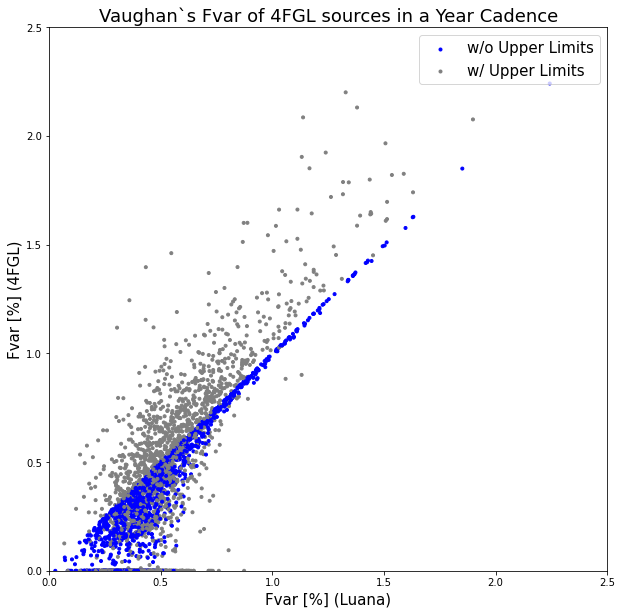

In [36]:
## Fvar 4FGL vs. Luana

plt.figure(figsize=(10, 10))

## Get the color values for the markers based on the Upper_limits column
colors = ['gray' if ul else 'blue' for ul in fvar_Luana_Vaughan['Upper_limits']]

plt.scatter(fvar_Luana_Vaughan['Frac_Variability'], catalog_with_fvar['Frac_Variability'], marker='.', c=colors)

plt.xlabel('Fvar [%] (Luana)', fontsize=15)
plt.ylabel('Fvar [%] (4FGL)', fontsize=15)  ## with Flux_History points
plt.title('Vaughan`s Fvar of 4FGL sources in a Year Cadence', fontsize=18)
# plt.legend()

legend_labels = ['w/o Upper Limits', 'w/ Upper Limits']
legend_handles = [plt.scatter([], [], color='blue', marker='.'), plt.scatter([], [], color='gray', marker='.')]
plt.legend(legend_handles, legend_labels, loc='upper right', fontsize=15)

plt.xlim(0,2.5)
plt.ylim(0,2.5)

# plt.xscale('log')
# plt.yscale('log')

plt.show()

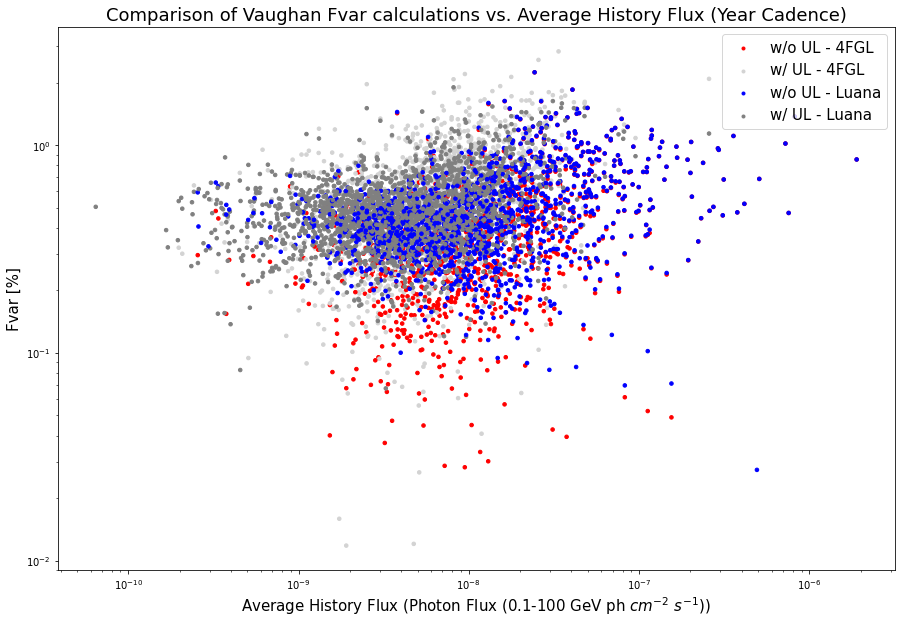

In [37]:
## Plot of Fvar(4FGL) vs average spectrum flux + Fvar(Luana) vs average history flux

## 4FGL
x1 = average_flux_Vaughan
y1 = catalog_with_fvar['Frac_Variability']

## Luana
x2 = average_flux_Vaughan
y2 = fvar_Luana_Vaughan['Frac_Variability']

## Get the color values for the markers based on the Upper_limits column
colors1 = ['lightgray' if ul else 'red' for ul in fvar_Luana_Vaughan['Upper_limits']]
colors2 = ['gray' if ul else 'blue' for ul in fvar_Luana_Vaughan['Upper_limits']]

plt.figure(figsize=(15, 10))

plt.scatter(x1, y1, label='4FGL', marker='.', c=colors1, s=50)
plt.scatter(x2, y2, label='Luana', marker='.', c=colors2, s=50)
plt.title('Comparison of Vaughan Fvar calculations vs. Average History Flux (Year Cadence)', fontsize=18)
plt.xlabel('Average History Flux (Photon Flux (0.1-100 GeV ph $cm^{-2}$ $s^{-1}$))', fontsize=15)
plt.ylabel('Fvar [%]', fontsize=15)

legend_labels = ['w/o UL - 4FGL', 'w/ UL - 4FGL', 'w/o UL - Luana', 'w/ UL - Luana']
legend_handles = [plt.scatter([], [], color='red', marker='.'), plt.scatter([], [], color='lightgray', marker='.'),
                 plt.scatter([], [], color='blue', marker='.'), plt.scatter([], [], color='gray', marker='.')]
plt.legend(legend_handles, legend_labels, loc='upper right', fontsize=15)

plt.xscale('log')
plt.yscale('log')

plt.show()

## Approach 2) 4FGL Paper - Abdollahi et. al 2020: F_var Calculations

$$ \text{Frac Variability} = \frac{\delta F}{F_{av}} $$

$$ \delta F = \sqrt{max{\left ( V_{ar} - \frac{\sum_{i} \sigma_{i}^{2}}{N_{int}}, 0 \right )}} $$

$$ V_{ar} = \frac{1}{N_{int} - 1} \sum_{i} \left ( F_{i} - F_{av} \right )^{2} $$

$$ \text{Unc Frac Variability} = \frac{\sigma_{F}}{F} = min{\left ( \frac{1}{\sqrt{2 \left (N_{int} - 1  \right )}} \frac{V_{i}}{F_{av} \ \delta F}, 10  \right )} $$

In [38]:
def calculate_Fvar_4FGL(history_flux, flux_error):
    ########## Description ##########
    # ---------- Input ----------
    # history_flux : history flux points from 4FGL                 (float)
    # flux_error   : error of the flux value                       (1D-array)
    # ---------- Output ----------
    # Fvar         : Fvar of the source            (float)
    # Fvar_error   : error of the value Fvar       (float)
    #################################
    
    F_av = sum(history_flux) / len(history_flux)
    var_sum = sum((F_i - F_av) ** 2 for F_i in history_flux)
    N_int = len(history_flux)
    V_ar = var_sum / (N_int - 1)

    delta_F = np.sqrt(max(V_ar - ( ( sum(sigma_i ** 2 for sigma_i in flux_error) ) / N_int ), 0))  # Calculate delta F

    frac_variability = delta_F / F_av  # Calculate fractional variability

    unc_frac_variability = min(( 1 / np.sqrt(2 * (N_int - 1)) ) * ( V_ar / (F_av * delta_F) ), 10)  # Calculate uncertainty of fractional variability
    
    return frac_variability, unc_frac_variability

In [39]:
def test_averaging_catalog_errors(catalog):
    all_fluxes = []
    all_flux_uncs = []
    for entry in catalog:
        fluxes = entry["Flux_History"]
        fluxes_unc = entry["Unc_Flux_History"][:, 1].copy()
        errors = catalog["Unc_Flux_History"][0][:]
        nan_locations = np.where(np.isnan(errors[:,0]))[0]
        for i, err in enumerate(errors):
            if i not in nan_locations:
#                 print(err)
                
                ## Average of errors
#                 fluxes_unc[i] = np.average(np.abs(err), axis=0)

                ## Minimum of errors
#                 fluxes_unc[i] = np.min(np.abs(err), axis=0)

                ## Maximum of errors
                fluxes_unc[i] = np.max(np.abs(err), axis=0)
#                 print(fluxes_unc[i])
            
        all_fluxes.append(fluxes)
        all_flux_uncs.append(fluxes_unc)
    return all_fluxes, all_flux_uncs

In [40]:
catalog_with_average = test_averaging_catalog_errors(catalog_with_flux_history)

# catalog_with_average

In [41]:
# catalog_with_average[0]

In [42]:
# catalog_with_average[1]

In [43]:
## Calculating F_var for each source

source_names_4FGL = []
source_has_UL_4FGL = []

## Masking Upper Limits
f_var_4FGL_no_UL = []
f_var_unc_4FGL_no_UL = []
average_flux_4FGL_no_UL = []

## Keeping UL and selecting the higher uncertainty
f_var_4FGL_w_UL = []
f_var_unc_4FGL_w_UL = []
average_flux_4FGL_w_UL = []

catalog_with_average = test_averaging_catalog_errors(catalog_with_flux_history)


for i in range(len(catalog_with_flux_history)):
    
    ## Selecting each source by name
    select_source = catalog_with_flux_history['Source_Name'][i]
    source_names_4FGL.append(f'{select_source}')
    
    ## Selecting the dataframe of the selected source
    source_df = catalog_with_flux_history[catalog_with_flux_history['Source_Name'] == f'{select_source}']

    ## Defining Flux Points and Uncertainties
    source_flux_history = source_df['Flux_History'][0][:]
    source_unc_flux = source_df['Unc_Flux_History'][0][:]
    
    ## True or False for ULs
    any_nan = np.isnan(source_df['Unc_Flux_History'][0][:,0])
    if any(any_nan):
        source_has_UL_4FGL.append(True) 
    else:
        source_has_UL_4FGL.append(False)
        
    
    ## Masking Upper Limits
    
    ## Creating a mask for upper limits
    mask_this_source = np.invert(np.isnan(source_df['Unc_Flux_History'][0][:,0]))
    ## Selecting the values that are not Upper Limits
    source_flux_history_no_UL = source_df['Flux_History'][0][mask_this_source]
    ## Choose the positive uncertainties (seems larger)
    source_unc_flux_no_UL = source_df['Unc_Flux_History'][0][:,1][mask_this_source]
    
        
    ## Keeping UL and selecting the higher uncertainty
    source_flux_history_w_UL = source_flux_history
    source_unc_flux_w_UL = source_df['Unc_Flux_History'][0][:,1]
    
    
    #### Averaging Error ###
#     source_flux_history = catalog_with_average[0][i]
#     source_unc_flux = catalog_with_average[1][i]
    ########################
    
    
    ## Masking Upper Limits
    fvar_source_no_UL, fvar_unc_source_no_UL = calculate_Fvar_4FGL(source_flux_history_no_UL, source_unc_flux_no_UL)
    
    f_var_4FGL_no_UL.append(fvar_source_no_UL)
    f_var_unc_4FGL_no_UL.append(fvar_unc_source_no_UL)
    average_flux_4FGL_no_UL.append(np.average(source_unc_flux_no_UL))

    
    ## Keeping UL and selecting the higher uncertainty
    fvar_source_w_UL, fvar_unc_source_w_UL = calculate_Fvar_4FGL(source_flux_history_w_UL, source_unc_flux_w_UL)
    
    f_var_4FGL_w_UL.append(fvar_source_w_UL)
    f_var_unc_4FGL_w_UL.append(fvar_unc_source_w_UL)
    average_flux_4FGL_w_UL.append(np.average(source_flux_history_w_UL))

/var/folders/sk/6dg2gqpn01x3m5hwkj90qkgw0000gp/T/ipykernel_55034/3669984372.py:20: RuntimeWarning: divide by zero encountered in double_scalars
  unc_frac_variability = min(( 1 / np.sqrt(2 * (N_int - 1)) ) * ( V_ar / (F_av * delta_F) ), 10)  # Calculate uncertainty of fractional variability
/var/folders/sk/6dg2gqpn01x3m5hwkj90qkgw0000gp/T/ipykernel_55034/3669984372.py:14: RuntimeWarning: invalid value encountered in double_scalars
  V_ar = var_sum / (N_int - 1)


In [44]:
len(source_names_4FGL)

3511

In [45]:
# f_var_4FGL_no_UL

In [46]:
# f_var_4FGL_w_UL

In [47]:
## Save the arrays with F_var information to a file

## Masking Upper Limits
np.savez('Fvar_year_no_UL.npz', array1=source_names_4FGL, array2=f_var_4FGL_no_UL, array3=f_var_unc_4FGL_no_UL, array4=average_flux_4FGL_no_UL)

## Keeping UL and selecting the higher uncertainty
np.savez('Fvar_year_w_UL.npz', array1=source_names_4FGL, array2=f_var_4FGL_w_UL, array3=f_var_unc_4FGL_w_UL, array4=average_flux_4FGL_w_UL)

In [48]:
## The sources with UL values (small ones) - taking the higher uncertainty

fvar_Luana_4FGL = pd.DataFrame({'Source_Name': source_names_4FGL, 'Frac_Variability': f_var_4FGL_w_UL,
                                'Unc_Frac_Variability': f_var_unc_4FGL_w_UL, 'Upper_limits': source_has_UL_4FGL})

fvar_Luana_4FGL

Source_Name  Frac_Variability  Unc_Frac_Variability  Upper_limits
0     J0001.2+4741          0.613565              0.459586          True
1     J0001.2-0747          0.328835              0.109704         False
2     J0001.5+2113          1.054583              0.249802         False
3     J0001.6-4156          0.300242              0.188030         False
4     J0002.1-6728          0.257381              0.228869         False
...            ...               ...                   ...           ...
3506  J2359.1+1719          0.000000             10.000000          True
3507  J2359.2-3134          1.221221              0.321734          True
3508  J2359.3+0215          0.000000             10.000000          True
3509  J2359.3-2049          0.000000             10.000000         False
3510  J2359.9-3736          0.000000             10.000000          True

[3511 rows x 4 columns]

In [49]:
catalog_with_fvar

<QTable length=3511>
Source_Name  Frac_Variability Unc_Frac_Variability
   str18         float32            float32       
------------ ---------------- --------------------
J0001.2+4741       0.69284904           0.40699458
J0001.2-0747       0.33279318          0.108399756
J0001.5+2113        1.0545832           0.24980173
J0001.6-4156       0.32796606           0.17213507
J0002.1-6728       0.30663496           0.19210596
J0002.3-0815       0.31231728           0.72063845
         ...              ...                  ...
J2359.0+3922        0.8606212           0.25553405
J2359.0-3038       0.15399826           0.17869046
J2359.1+1719              0.0                 10.0
J2359.2-3134        1.2248484           0.32078165
J2359.3+0215        0.3452614             0.969457
J2359.3-2049       0.12375273           0.24667947
J2359.9-3736              0.0                 10.0

In [50]:
# mask = catalog_with_fvar['Unc_Frac_Variability'] == 10

# catalog_with_fvar[mask]

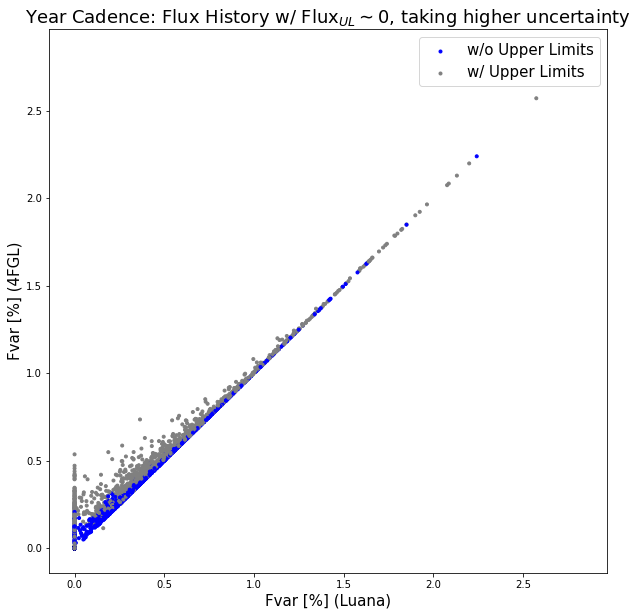

In [51]:
## Fvar 4FGL vs. Luana

plt.figure(figsize=(10, 10))


######## with UL ########
## Get the color values for the markers based on the Upper_limits column
colors = ['gray' if ul else 'blue' for ul in fvar_Luana_4FGL['Upper_limits']]
plt.scatter(fvar_Luana_4FGL['Frac_Variability'], catalog_with_fvar['Frac_Variability'], marker='.', c=colors)
#########################


######### no UL #########
# plt.scatter(fvar_Luana_4FGL['Frac_Variability'], catalog_with_fvar['Frac_Variability'], marker='.')
#########################

plt.xlabel('Fvar [%] (Luana)', fontsize=15) ## with Flux_History points
plt.ylabel('Fvar [%] (4FGL)', fontsize=15)
plt.title('Year Cadence: Flux History w/ Flux$_{UL} \sim 0$, taking higher uncertainty', fontsize=18)

legend_labels = ['w/o Upper Limits', 'w/ Upper Limits']
legend_handles = [plt.scatter([], [], color='blue', marker='.'), plt.scatter([], [], color='gray', marker='.')]
plt.legend(legend_handles, legend_labels, loc='upper right', fontsize=15)

# plt.xlim(0,2.5)
# plt.ylim(0,2.5)

# plt.xscale('log')
# plt.yscale('log')

plt.show()

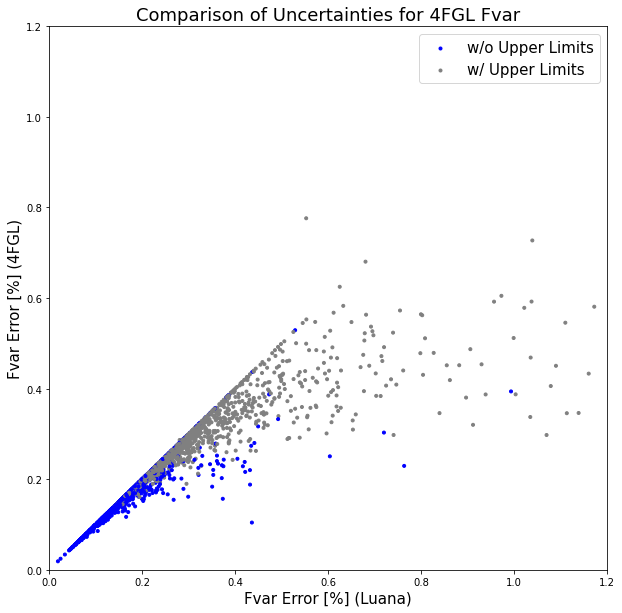

In [52]:
## Fvar 4FGL vs. Luana

plt.figure(figsize=(10, 10))

# Get the color values for the markers based on the Upper_limits column
colors = ['gray' if ul else 'blue' for ul in fvar_Luana_4FGL['Upper_limits']]
plt.scatter(fvar_Luana_4FGL['Unc_Frac_Variability'], catalog_with_fvar['Unc_Frac_Variability'], marker='.', c=colors)

plt.xlabel('Fvar Error [%] (Luana)', fontsize=15)
plt.ylabel('Fvar Error [%] (4FGL)', fontsize=15)  ## with Flux_History points
plt.title('Comparison of Uncertainties for 4FGL Fvar', fontsize=18)

legend_labels = ['w/o Upper Limits', 'w/ Upper Limits']
legend_handles = [plt.scatter([], [], color='blue', marker='.'), plt.scatter([], [], color='gray', marker='.')]
plt.legend(legend_handles, legend_labels, loc='upper right', fontsize=15)

plt.xlim(0,1.2)
plt.ylim(0,1.2)

# plt.xscale('log')
# plt.yscale('log')

plt.show()

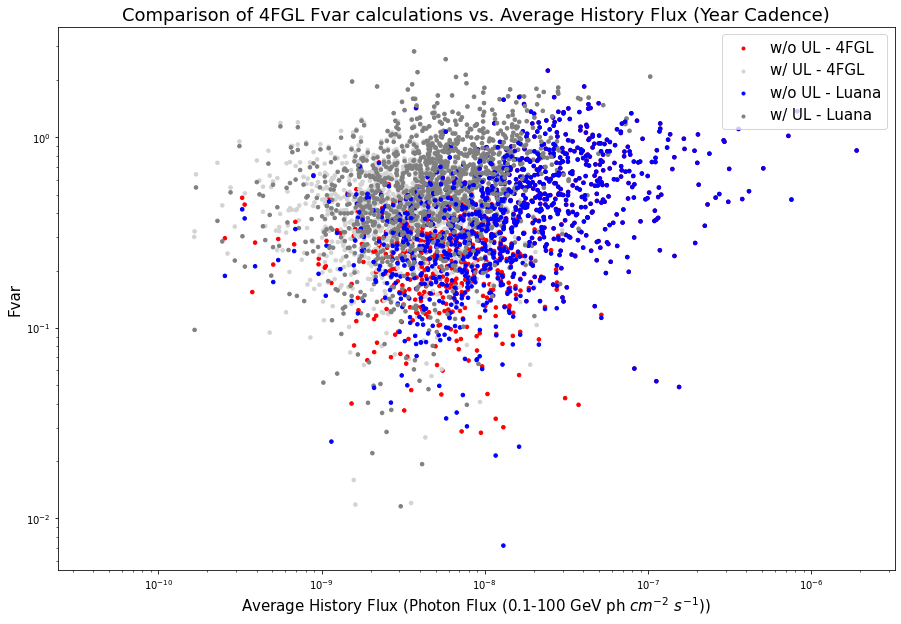

In [53]:
## Plot of Fvar(4FGL) vs average spectrum flux + Fvar(Luana) vs average history flux

## 4FGL
x1 = average_flux_4FGL_w_UL
y1 = catalog_with_fvar['Frac_Variability']

## Luana
x2 = average_flux_4FGL_w_UL
y2 = fvar_Luana_4FGL['Frac_Variability']

## Get the color values for the markers based on the Upper_limits column
colors1 = ['lightgray' if ul else 'red' for ul in fvar_Luana_4FGL['Upper_limits']]
colors2 = ['gray' if ul else 'blue' for ul in fvar_Luana_4FGL['Upper_limits']]

plt.figure(figsize=(15, 10))

plt.scatter(x1, y1, marker='.', c=colors1, s=50, label='4FGL')
plt.scatter(x2, y2, marker='.', c=colors2, s=50, label='Luana')
plt.title('Comparison of 4FGL Fvar calculations vs. Average History Flux (Year Cadence)', fontsize=18)
plt.xlabel('Average History Flux (Photon Flux (0.1-100 GeV ph $cm^{-2}$ $s^{-1}$))', fontsize=15)
plt.ylabel('Fvar', fontsize=15)
plt.legend(fontsize=15)

legend_labels = ['w/o UL - 4FGL', 'w/ UL - 4FGL', 'w/o UL - Luana', 'w/ UL - Luana']
legend_handles = [plt.scatter([], [], color='red', marker='.'), plt.scatter([], [], color='lightgray', marker='.'),
                 plt.scatter([], [], color='blue', marker='.'), plt.scatter([], [], color='gray', marker='.')]
plt.legend(legend_handles, legend_labels, loc='upper right', fontsize=15)

plt.xscale('log')
plt.yscale('log')

plt.show()

/var/folders/sk/6dg2gqpn01x3m5hwkj90qkgw0000gp/T/ipykernel_55034/3123312235.py:5: RuntimeWarning: divide by zero encountered in true_divide
  y1 = catalog_with_fvar['Unc_Frac_Variability'] / catalog_with_fvar['Frac_Variability']


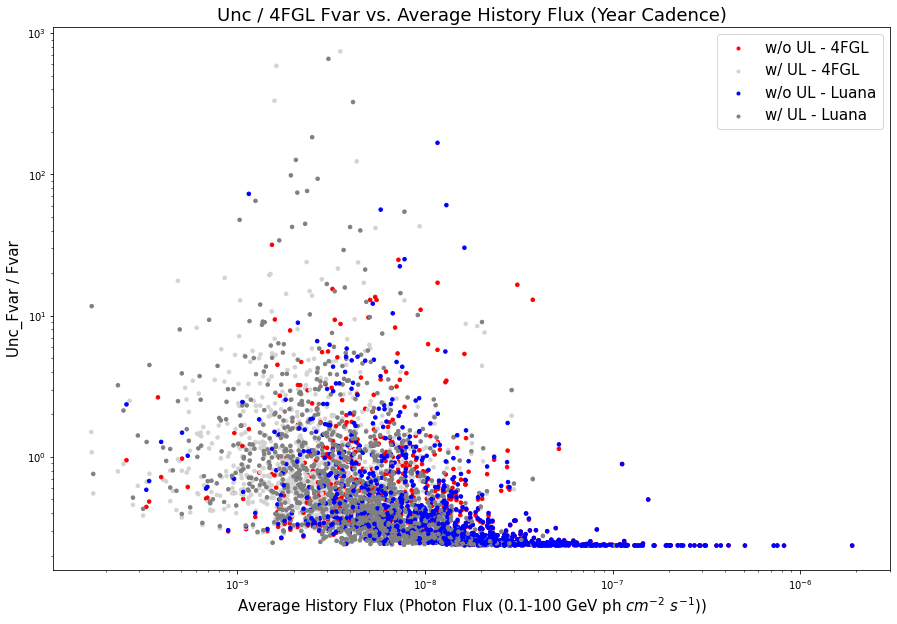

In [54]:
## Plot of Fvar(4FGL) vs average spectrum flux + Fvar(Luana) vs average history flux

## 4FGL
x1 = average_flux_4FGL_w_UL
y1 = catalog_with_fvar['Unc_Frac_Variability'] / catalog_with_fvar['Frac_Variability']

## Luana
x2 = average_flux_4FGL_w_UL
y2 = fvar_Luana_4FGL['Unc_Frac_Variability'] / fvar_Luana_4FGL['Frac_Variability']

## Get the color values for the markers based on the Upper_limits column
colors1 = ['lightgray' if ul else 'red' for ul in fvar_Luana_4FGL['Upper_limits']]
colors2 = ['gray' if ul else 'blue' for ul in fvar_Luana_4FGL['Upper_limits']]

plt.figure(figsize=(15, 10))

plt.scatter(x1, y1, marker='.', c=colors1, s=50, label='4FGL')
plt.scatter(x2, y2, marker='.', c=colors2, s=50, label='Luana')
plt.title('Unc / 4FGL Fvar vs. Average History Flux (Year Cadence)', fontsize=18)
plt.xlabel('Average History Flux (Photon Flux (0.1-100 GeV ph $cm^{-2}$ $s^{-1}$))', fontsize=15)
plt.ylabel('Unc_Fvar / Fvar', fontsize=15)
plt.legend(fontsize=15)

legend_labels = ['w/o UL - 4FGL', 'w/ UL - 4FGL', 'w/o UL - Luana', 'w/ UL - Luana']
legend_handles = [plt.scatter([], [], color='red', marker='.'), plt.scatter([], [], color='lightgray', marker='.'),
                 plt.scatter([], [], color='blue', marker='.'), plt.scatter([], [], color='gray', marker='.')]
plt.legend(legend_handles, legend_labels, loc='upper right', fontsize=15)

plt.xscale('log')
plt.yscale('log')

plt.show()

In [ ]:
# ## Saving the dataframe as a .csv table

# ## Here we have the sources with UL values (small ones) - taking the higher uncertainty

# fvar_Luana_4FGL.to_pandas().to_csv('Fvar_year_Luana_data.csv', index=False)

## Examples Tarek:

In [55]:
catalog_with_flux_history['Flux_History'][0]

array([3.2381073e-09, 6.2654388e-09, 5.3481841e-09, 7.9557583e-14,
       6.5167382e-15, 3.0029751e-14, 3.4034604e-09, 1.1556166e-09,
       2.0116395e-09, 3.7488209e-13], dtype=float32)

In [56]:
catalog_with_flux_history['Unc_Flux_History'][0]

array([[-1.7942571e-09,  2.0774948e-09],
       [-1.8782995e-09,  2.1424658e-09],
       [-1.9150088e-09,  2.1906275e-09],
       [           nan,  1.3167837e-09],
       [           nan,  1.6244933e-09],
       [           nan,  2.3319167e-09],
       [-1.9609092e-09,  2.3040045e-09],
       [           nan,  1.6207169e-09],
       [-1.2986654e-09,  1.6936006e-09],
       [           nan,  1.8192396e-09]], dtype=float32)

Value "nan" in the uncertainties means that it is an upper limit point

In [57]:
## Extracting flux points and errors

## Values that are not upper limits
mask = np.invert(np.isnan(catalog_with_flux_history['Unc_Flux_History'][0][:,0]))
## Flux points
flux = catalog_with_flux_history['Flux_History'][0][mask]
## Uncertainties taken from the positive one (seems larger)
flux_unc = catalog_with_flux_history['Unc_Flux_History'][0][:,1][mask]

## Extracting Upper Limit points
ul_mask = np.isnan(catalog_with_flux_history['Unc_Flux_History'][0][:,0])
flux_uls = catalog_with_flux_history['Unc_Flux_History'][0][:,1][ul_mask]

In [58]:
flux

array([3.2381073e-09, 6.2654388e-09, 5.3481841e-09, 3.4034604e-09,
       2.0116395e-09], dtype=float32)

In [59]:
flux_unc

array([2.0774948e-09, 2.1424658e-09, 2.1906275e-09, 2.3040045e-09,
       1.6936006e-09], dtype=float32)

In [60]:
flux_uls

array([1.3167837e-09, 1.6244933e-09, 2.3319167e-09, 1.6207169e-09,
       1.8192396e-09], dtype=float32)